<a href="https://colab.research.google.com/github/suhrobm/Continuous-Mathematical-Modeling/blob/commonbranch/CMM_Inversion_Munavarov_Suhrob_J4234c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Course Project: Inversion of Win-Lose Scenario Assessment**

---

In this project, we are going to;
  
* demonstrate how to perform Bayesian inference on a system of ordinary differential equations (without gradients),
* solve the ODE using scipy.odeint and (non-Bayesian) least squares optimization and
* perform Bayesian inference in PyMC using non-gradient-based samplers, that is, gradient-free Bayesian inference in PyMC.

---

### **Content** 🎯

The aim is to find out values of given model parameters. For this, a natural choice to estimate the values and uncertainty of model parameters given experimental data is to use Bayesian inference method.

Thusm, our purpose of this analysis is to estimate, with uncertainty, the parameters for the given model for historical data from 1900 to 1935.



**Remarques:**

What is PyMC?


> PyMC is a probabilistic programming library for Python that provides tools for constructing and fitting Bayesian models. It offers an intuitive, readable syntax that is close to the natural syntax statisticians use to describe models.


What is Bayesian inference?

> Bayesian modeling is able to incorporate prior knowledge into the model. It allows to calculate the posterior (or "updated") probability. This is a conditional probability.






In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from ipywidgets import interact
import warnings

from google.colab import drive
drive.mount('/content/drive')

# prevents numpy scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format})
# ignoring warnings
warnings.filterwarnings(action='ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
''' reading whole dataset from the file and loading the data and save it in a working_df DataFrame
    data taken from http://people.whitman.edu/~hundledr/courses/M250F03/M250.html
'''
path = '/content/drive/MyDrive/ITMO/CMM/LynxHare.txt'
working_df = pd.read_csv(path, delim_whitespace=True, header=None)
working_df.head(10)

,0,1,2
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23
5,1850,58.00,8.42
6,1851,74.60,5.56
7,1852,75.09,5.08
8,1853,88.48,10.17
9,1854,61.28,19.60


In [118]:
''' here above, we can see that the columns in the working_df DataFrame are unnamed. So, we can add/name columns
    to an existing working_df DataFrame using its columns attribute.

'''
working_df.columns = ['Year', 'Hare', 'Lynx']  # naming columns respectively
working_df.head(10)

,Year,Hare,Lynx
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23
5,1850,58.00,8.42
6,1851,74.60,5.56
7,1852,75.09,5.08
8,1853,88.48,10.17
9,1854,61.28,19.60


In [119]:
working_df = working_df.loc[working_df['Year']>=1900]
working_df

,Year,Hare,Lynx
55,1900,12.82,7.13
56,1901,4.72,9.47
57,1902,4.73,14.86
58,1903,37.22,31.47
59,1904,69.72,60.57
60,1905,57.78,63.51
61,1906,28.68,54.70
62,1907,23.37,6.30
63,1908,21.54,3.41
64,1909,26.34,5.44


In [120]:
# plot data function for reuse later
def plot_data(ax, lw=1, title="Hare/Lynx Population Dynamics"):

    ax.plot(working_df.Year, working_df.Lynx, color="c", lw=lw, marker="o", markersize=12, label="Lynx")
    ax.plot(working_df.Year, working_df.Hare, color="y", lw=lw, marker="+", markersize=14, label="Hare")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylim(-5)
    ax.grid(True)
    ax.set_xlabel("Shortened Time Period", fontsize=10)
    ax.set_ylabel("Thousands of animals", fontsize=10)
    ax.set_xticks(working_df.Year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=12)

    return ax

<Axes: title={'center': 'Hare/Lynx Population Dynamics'}, xlabel='Shortened Time Period', ylabel='Thousands of animals'>

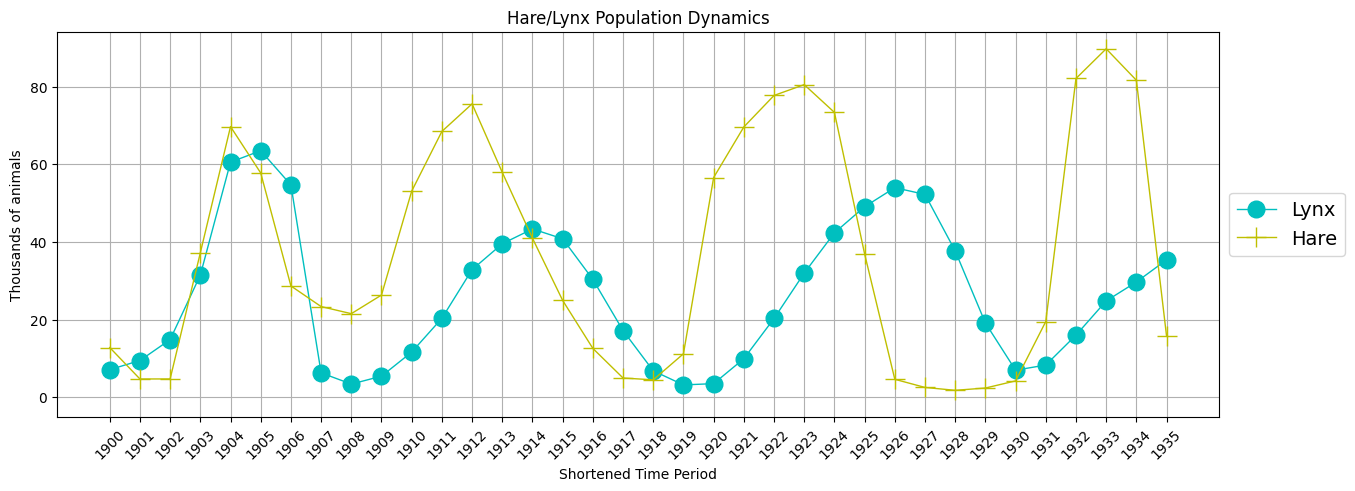

In [121]:
_ , ax = plt.subplots(figsize=(15, 5))
plot_data(ax)

In [122]:
''' function that calculates residuals based on a given inverse_parameters

    now, we can solve the ODE using least squares. Below function calculates the residual error.

    setting same parameters' values (previous from the 1. part of the course project) to the inverse_parameters variable again

'''

inverse_parameters = np.array([3.2, 0.6, 50, 0.56, 1.6, 153, 20, 20])

def ode_model_resid(inverse_parameters):
    return (
             working_df[["Hare", "Lynx"]] - odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=working_df.Year, args=(inverse_parameters,))
           ).values.flatten()

# **PyMC Model Specification**




* Like other Numpy or Scipy-based functions, the scipy.integrate.odeint function cannot be used directly in a PyMC model because PyMC needs to know the variable input and output types to compile. Therefore, we use a Pytensor wrapper to give the variable types to PyMC. Then the function can be used in PyMC in conjunction with gradient-free samplers.







In [123]:

''' decorator with input and output types a Pytensor double float tensors

    convert python function to a Pytensor Operator using @as_op decorator. We tell PyMC the input variable types and the output variable
    types using the @as_op decorator. odeint returns Numpy arrays, but we tell PyMC that they are Pytensor double float tensors for this purpose.

'''

@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(inverse_parameters):
    return odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=working_df.Year, args=(inverse_parameters,))

In [124]:
''' defining the right hand side of the ODE equations in the Scipy odeint signature

    here, we updated to derivative_inverse function that represents the right-hand-side of the ODE equations
    with the call signature needed for the odeint function.

'''

def derivative_inverse(X, t, inverse_parameters):

    # unpacking parameters
    Hare, Lynx = X
    a, b, c, d, r, hare_k, Hare0, Lynx0 = inverse_parameters

    dHare = r * Hare * (1 - Hare/hare_k) - a * Hare * Lynx/(c + Hare)   # model for Hare
    dLynx = b * a * Hare * Lynx/(c + Hare) - d * Lynx                   # model for Lynx
    return [dHare, dLynx]



In [125]:
'''
    calculating least squares using the Scipy solver

'''

results = least_squares(ode_model_resid, inverse_parameters)
inverse_parameters = results.x  # least squares solution used to inform the priors(~ previous values)

In [126]:
''' now, we can specify the PyMC model using the ode solver! For priors, we will use the results from the least squares calculation
    (results.x) to assign priors that start in the right range. These are empirically derived weakly informative priors. We also make
    them positive-only for this problem.

    we will use a normal likelihood on untransformed data (i.e., not log transformed) to best fit the peaks of the data.

'''

inverse_parameters = results.x  # least squares solution used to inform the priors(~ previous values)

with pm.Model() as model:
    # Priors
    a = pm.TruncatedNormal("a", mu=inverse_parameters[0], sigma=0.1, lower=0, initval=inverse_parameters[0])
    b = pm.TruncatedNormal("b", mu=inverse_parameters[1], sigma=0.01, lower=0, initval=inverse_parameters[1])
    c = pm.TruncatedNormal("c", mu=inverse_parameters[2], sigma=0.1, lower=0, initval=inverse_parameters[2])
    d = pm.TruncatedNormal("d", mu=inverse_parameters[3], sigma=0.01, lower=0, initval=inverse_parameters[3])
    r = pm.TruncatedNormal("r", mu=inverse_parameters[4], sigma=1, lower=0, initval=inverse_parameters[4])
    hare_k = pm.TruncatedNormal("hare_k", mu=inverse_parameters[5], sigma=1, lower=0, initval=inverse_parameters[5])
    Hare0 = pm.TruncatedNormal("Hare0", mu=inverse_parameters[6], sigma=1, lower=0, initval=inverse_parameters[6])
    Lynx0 = pm.TruncatedNormal("Lynx0", mu=inverse_parameters[7], sigma=1, lower=0, initval=inverse_parameters[7])
    sigma = pm.HalfNormal("sigma", 10)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([a, b, c, d, r, hare_k, Hare0, Lynx0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=working_df[["Hare", "Lynx"]].values)


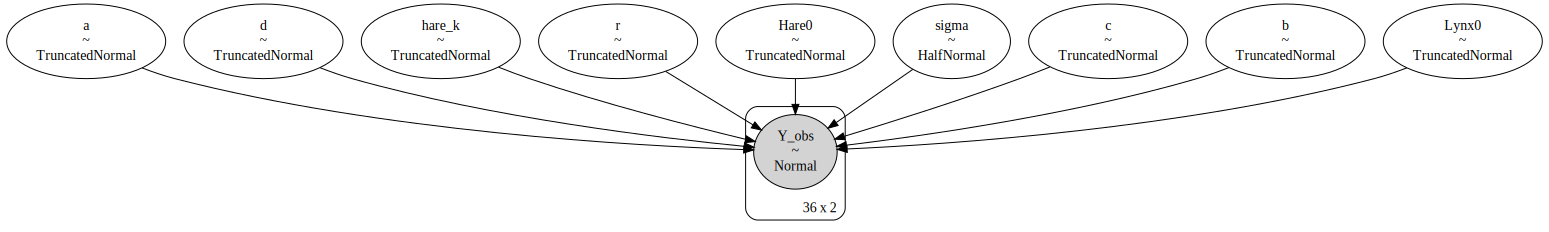

In [127]:
pm.model_to_graphviz(model)

# **Sampler without gradient**



* Having good gradient free samplers can open up the models that can be fit within PyMC. Actually there are five options for gradient-free samplers in PyMC that are applicable to this problem but we will see here, the Sequential Monte Carlo (SMC) sampler.

*   The Sequential Monte Carlo (SMC) sampler can be used to sample a regular Bayesian model or to run model without a likelihood (Aproximate Bayesian Computation). Let’s try not with a regular model, but run with model without a likelihood, that is, using pm.Simulator with Epsilon = 10.


In [128]:
''' simulator function based on the signature rng, parameters, size

    as outlined in the SMC tutorial on PyMC.io, the SMC sampler can be used for Aproximate Bayesian Computation,
    i.e. we can use a pm.Simulator instead of a explicit likelihood. Here is a rewrite of the PyMC - odeint model for SMC-ABC.

    the simulator function needs to have the correct signature (e.g., accept an rng argument first)

'''

def simulator_forward_model(rng, a, b, c, d, r, hare_k, Hare0, Lynx0, sigma, size=None):
    inverse_parameters = a, b, c, d, r, hare_k, Hare0, Lynx0
    mu = odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=working_df.Year, args=(inverse_parameters,))
    return rng.normal(mu, sigma)

In [129]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    a = pm.TruncatedNormal("a", mu=inverse_parameters[0], sigma=0.1, lower=0, initval=inverse_parameters[0])
    b = pm.TruncatedNormal("b", mu=inverse_parameters[1], sigma=0.01, lower=0, initval=inverse_parameters[1])
    c = pm.TruncatedNormal("c", mu=inverse_parameters[2], sigma=0.1, lower=0, initval=inverse_parameters[2])
    d = pm.TruncatedNormal("d", mu=inverse_parameters[3], sigma=0.01, lower=0, initval=inverse_parameters[3])
    r = pm.TruncatedNormal("r", mu=inverse_parameters[4], sigma=1, lower=0, initval=inverse_parameters[4])
    hare_k = pm.TruncatedNormal("hare_k", mu=inverse_parameters[5], sigma=1, lower=0, initval=inverse_parameters[5])
    Hare0 = pm.TruncatedNormal("Hare0", mu=inverse_parameters[6], sigma=1, lower=0, initval=inverse_parameters[6])
    Lynx0 = pm.TruncatedNormal("Lynx0", mu=inverse_parameters[7], sigma=1, lower=0, initval=inverse_parameters[7])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    pm.Simulator("Y_obs", simulator_forward_model, params=(a, b, c, d, r, hare_k, Hare0, Lynx0, sigma), epsilon=10, observed=working_df[["Hare", "Lynx"]].values,)



In [130]:
''' now, by setting the value 10 for Epsilon, we can see that the SMC sampler (plus simulator) provides good results.
    choosing a value for epsilon will always involve some trial and error, so be attentive.

'''

sampler = "SMC epsilon = 10"
draws = 2000
with model:
    trace_SMC_e10 = pm.sample_smc(draws)
trace = trace_SMC_e10
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.364,0.062,3.244,3.468,0.007,0.005,99.0,60.0,1.10
b,0.416,0.007,0.403,0.428,0.000,0.000,190.0,156.0,1.02
c,36.515,0.123,36.368,36.760,0.030,0.022,14.0,55.0,1.10
d,0.562,0.008,0.546,0.575,0.001,0.001,80.0,105.0,1.07
r,2.099,0.052,2.003,2.192,0.008,0.006,46.0,15.0,1.05
hare_k,119.485,0.774,117.824,120.718,0.080,0.057,81.0,137.0,1.04
Hare0,17.339,0.953,15.316,18.718,0.123,0.087,83.0,23.0,1.02
Lynx0,23.143,0.831,21.860,24.752,0.133,0.095,42.0,137.0,1.05
sigma,4.047,1.710,0.123,6.016,0.245,0.190,53.0,26.0,1.06


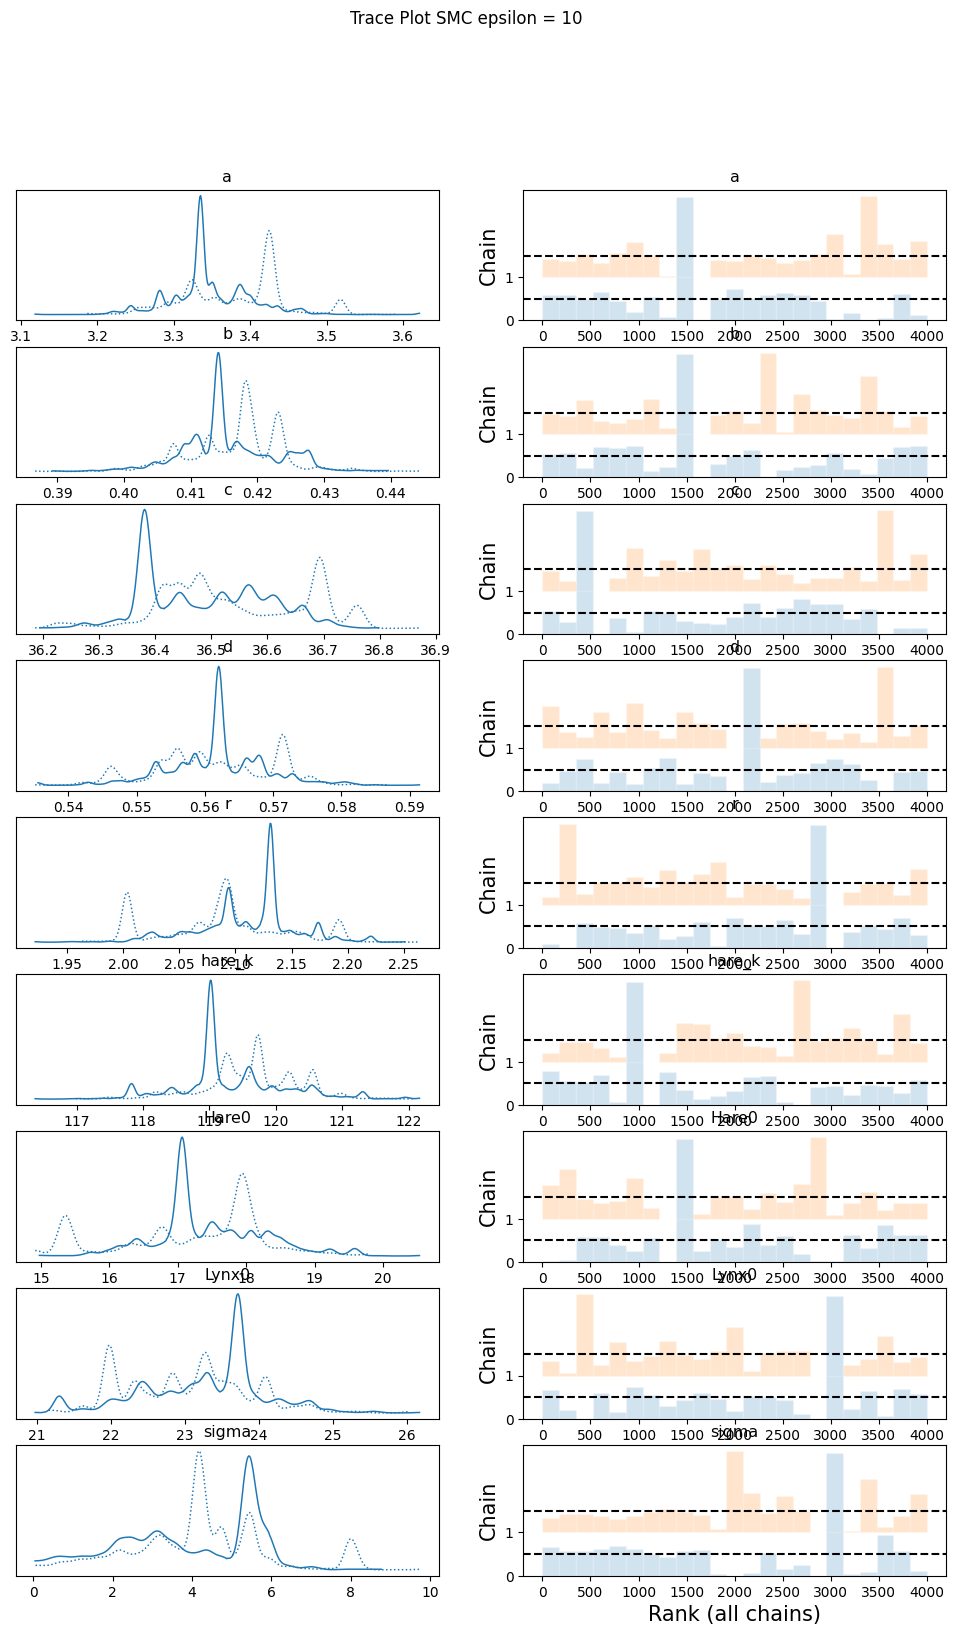

In [131]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

In [132]:
''' plotting model function
'''

def plot_model(
    ax,
    x_y,
    time=working_df.Year,
    alpha=1,
    lw=3,
    title="Hare/Lynx Population Dynamics and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="c", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="y", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    return ax

In [133]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):

    cols = ["a", "b", "c", "d", "r", "hare_k", "Hare0", "Lynx0"]
    row = trace_df.iloc[row_idx, :][cols].values

    # a, b, c, d, r, hare_k, Hare0, Lynx0
    time = working_df.Year
    inverse_parameters = row
    x_y = odeint(func=derivative_inverse, y0=inverse_parameters[-2:], t=time, args=(inverse_parameters,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [134]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hare/Lynx Population Dynamics and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=12)
    ax.grid(True)

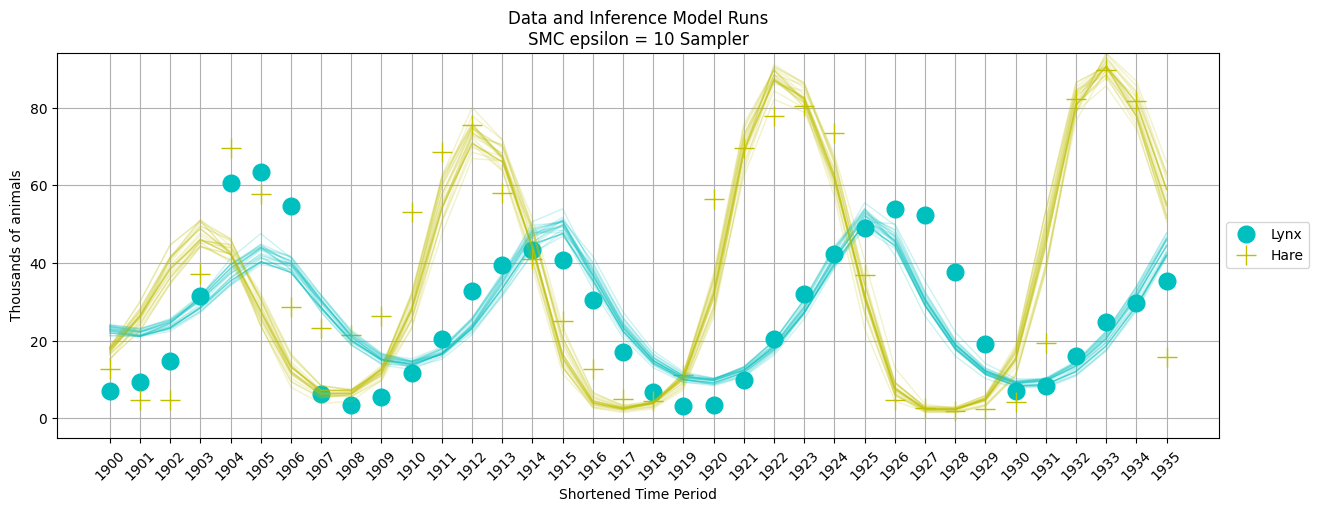

In [135]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

# **Posterior(updated) Correlations**


*   As an aside, it is worth pointing out that the posterior parameter space is a difficult geometry for sampling.


*   The major observation here is that the posterior shape is pretty difficult for a sampler to handle, with positive correlations, negative correlations, crescent-shapes, and large variations in scale. This is also fun to look at for understanding how the model parameters impact each other.




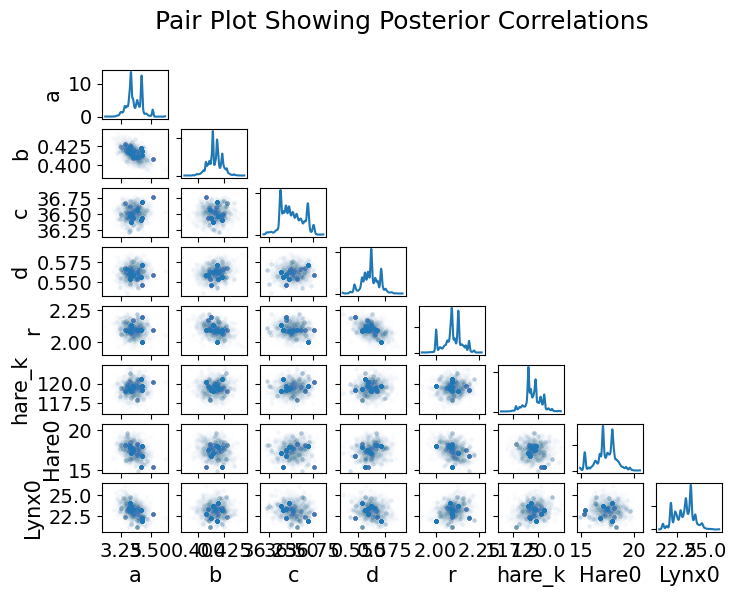

In [136]:
az.plot_pair(trace_SMC_e10, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);